In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Load Dataset

In [2]:
data_dir  = '/content/drive/MyDrive/Garbage classification'#Folder path
classes = os.listdir(data_dir)
print(classes)

['glass', 'plastic', 'trash', 'cardboard', 'metal', 'paper', 'garbage_classification_model.pth']


### Data Preprocessing

In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

dataset

Dataset ImageFolder
    Number of datapoints: 2537
    Root location: /content/drive/MyDrive/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [4]:
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')  # Hide the axis
    plt.show()

Label: cardboard (Class No: 0)


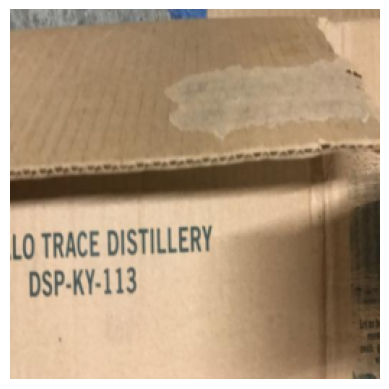

In [5]:
img, label = dataset[12]
show_sample(img, label)

Label: glass (Class No: 1)


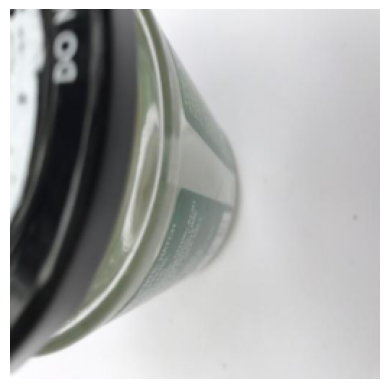

In [6]:
img, label = dataset[450]
show_sample(img, label)

In [7]:
random_seed = 42
torch.manual_seed(random_seed)

### Splitting Dataset for Train, Validate and Test

In [8]:
# Calculate the total length of the dataset
total_len = len(dataset)

# Define desired proportions for train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

# Calculate lengths based on proportions and total length
train_len = int(train_ratio * total_len)
val_len = int(val_ratio * total_len)
test_len = total_len - train_len - val_len  # Ensure total length is maintained

# Perform the split using the calculated lengths
train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])

# Print the lengths of the splits to verify
len(train_ds), len(val_ds), len(test_ds)

(1775, 253, 509)

In [9]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [10]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break

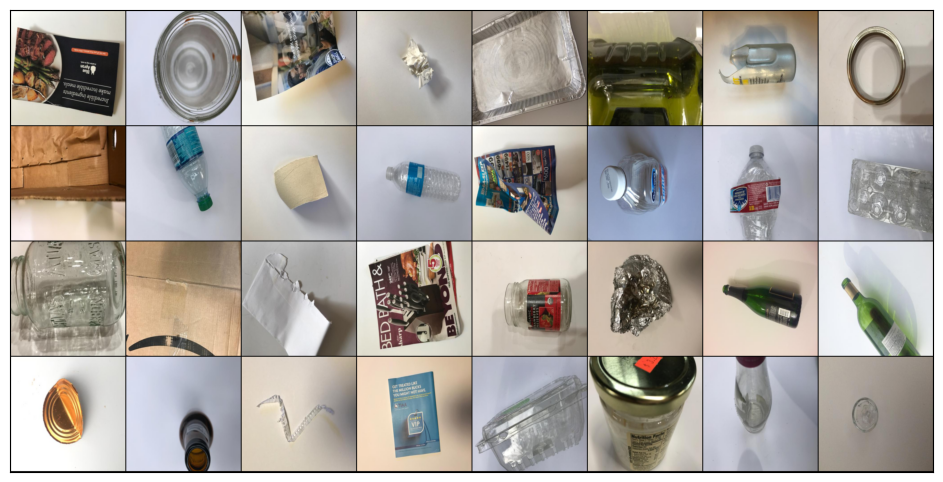

In [12]:
show_batch(train_dl)

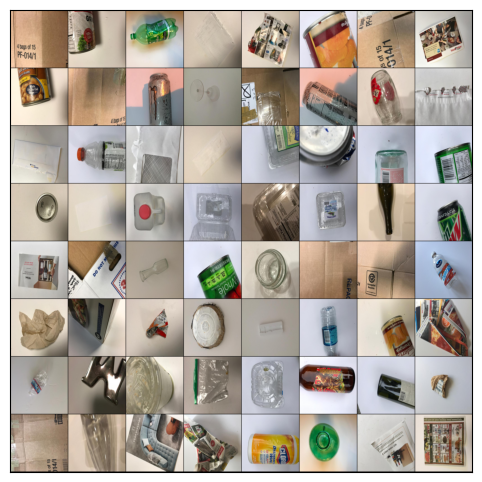

In [13]:
show_batch(val_dl)

### Model Defining

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)

        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 112MB/s]


In [16]:
def get_default_device():

    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

### Model Training and Evaluating 

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
model = to_device(ResNet(), device)

In [21]:
evaluate(model, val_dl)

{'val_loss': 1.775434136390686, 'val_acc': 0.21830174326896667}

In [22]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4464, val_loss: 1.2216, val_acc: 0.8891
Epoch 2: train_loss: 1.1643, val_loss: 1.1489, val_acc: 0.9282
Epoch 3: train_loss: 1.0875, val_loss: 1.1178, val_acc: 0.9520
Epoch 4: train_loss: 1.0660, val_loss: 1.1167, val_acc: 0.9403
Epoch 5: train_loss: 1.0660, val_loss: 1.1053, val_acc: 0.9639
Epoch 6: train_loss: 1.0606, val_loss: 1.0968, val_acc: 0.9602
Epoch 7: train_loss: 1.0569, val_loss: 1.1206, val_acc: 0.9242
Epoch 8: train_loss: 1.0530, val_loss: 1.1189, val_acc: 0.9209
Epoch 9: train_loss: 1.0514, val_loss: 1.1062, val_acc: 0.9444
Epoch 10: train_loss: 1.0507, val_loss: 1.1015, val_acc: 0.9520
Epoch 11: train_loss: 1.0517, val_loss: 1.0983, val_acc: 0.9440
Epoch 12: train_loss: 1.0543, val_loss: 1.1052, val_acc: 0.9559
Epoch 13: train_loss: 1.0545, val_loss: 1.1001, val_acc: 0.9404
Epoch 14: train_loss: 1.0480, val_loss: 1.0860, val_acc: 0.9641
Epoch 15: train_loss: 1.0491, val_loss: 1.1117, val_acc: 0.9322


### Visualizing the Result

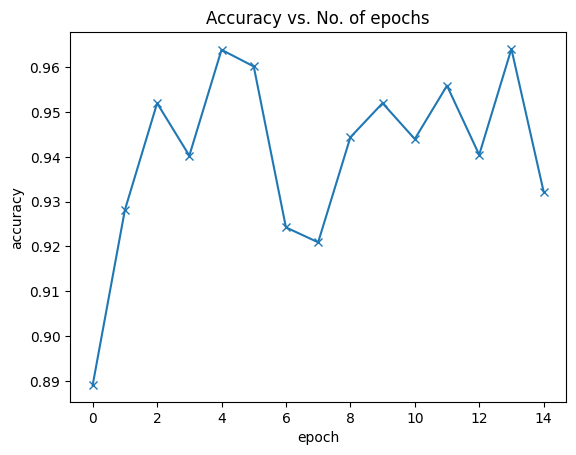

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

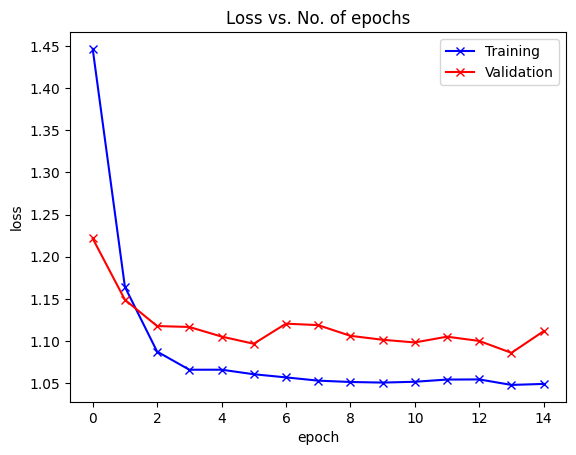

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

### Classifying the Images using Model 

In [25]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    plt.axis('off')
    return dataset.classes[preds[0].item()]

Predicted: glass


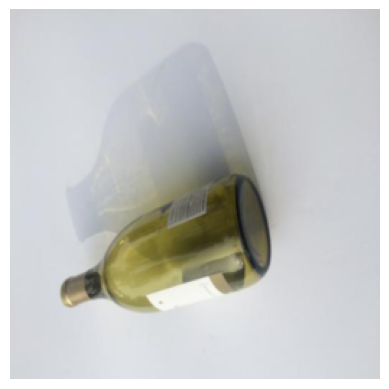

In [26]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


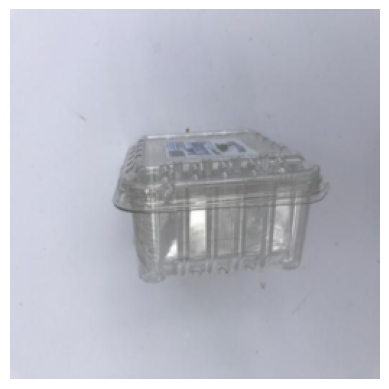

In [27]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Predicted: cardboard


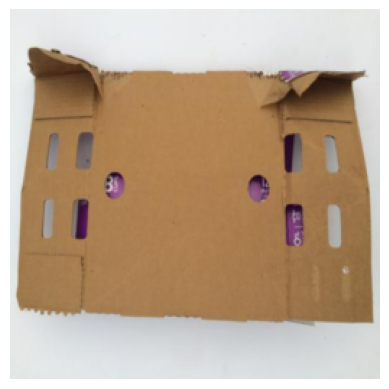

In [28]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

Predicted: cardboard


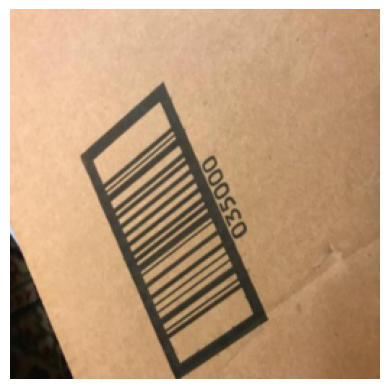

In [29]:
img, label = test_ds[4]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

Predicted: paper


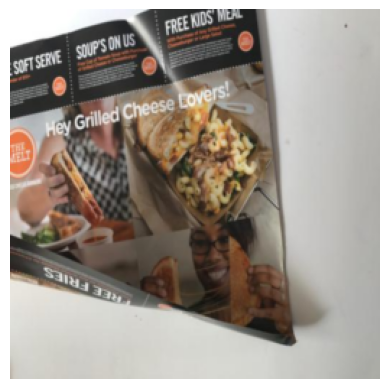

In [30]:
img, label = test_ds[19]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

Predicted: glass


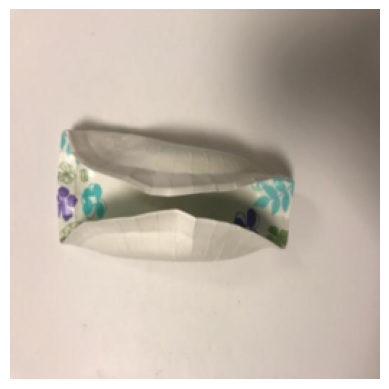

In [31]:
img, label = test_ds[5]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

In [32]:
import urllib.request
urllib.request.urlretrieve("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR3AtmERYQU8VUf2Kve2lJ-PFVrGyqSfQkmOA&s", "plastic.jpg")

urllib.request.urlretrieve("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRVesCOY6I9LMc-jzGWfzDgHfGVyWn0oClMlg&s", "cardboard.jpg")

urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.2F0uH6BguQMctAYEJ-s-1gHaHb%26pid%3DApi&f=1", "cans.jpg")

urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftinytrashcan.com%2Fwp-content%2Fuploads%2F2018%2F08%2Ftiny-trash-can-bulk-wine-bottle.jpg&f=1&nofb=1", "wine-trash.jpg")

urllib.request.urlretrieve("https://media.istockphoto.com/id/172415947/photo/crumpled-wad-of-paper-for-trash.jpg?s=612x612&w=0&k=20&c=b0Ty6OGTC8O3AL1c6CFd7tRBqA1ePjoYsYSDsZqMipc=", "paper-trash.jpg")

urllib.request.urlretrieve("https://programmingaltanai.files.wordpress.com/2020/09/1.jpg?w=616", "mixed-trash.jpg")

('mixed-trash.jpg', <http.client.HTTPMessage at 0x7f9dc57ea650>)

In [33]:
loaded_model = model

In [34]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

The image resembles metal.


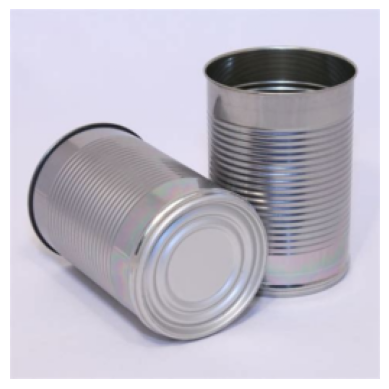

In [35]:
predict_external_image('cans.jpg')

The image resembles cardboard.


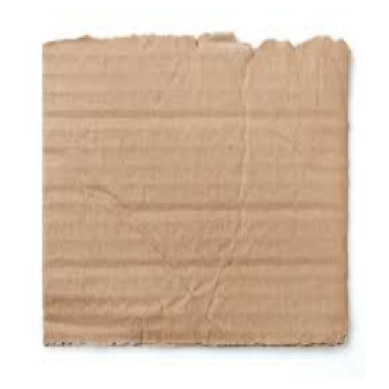

In [36]:
predict_external_image('cardboard.jpg')

The image resembles plastic.


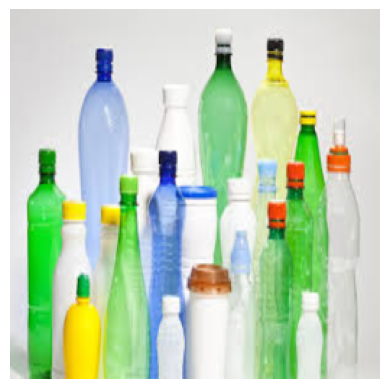

In [37]:
predict_external_image('plastic.jpg')

The image resembles cardboard.


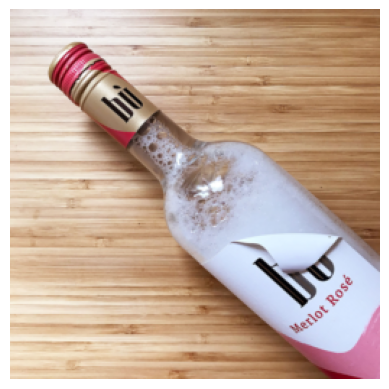

In [38]:
predict_external_image('wine-trash.jpg')

The image resembles paper.


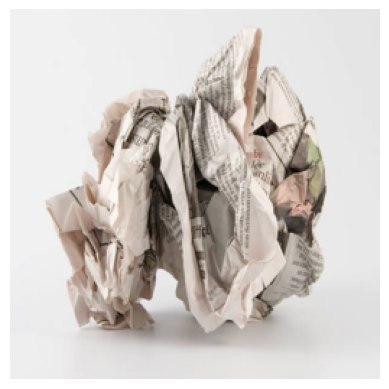

In [39]:
predict_external_image('paper-trash.jpg')

The image resembles paper.


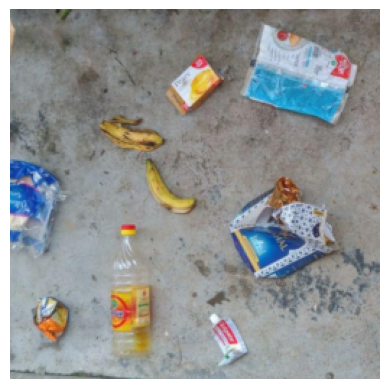

In [40]:
predict_external_image('mixed-trash.jpg')